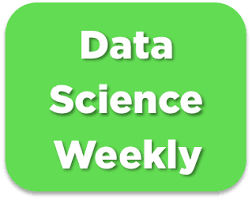

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.ensemble import RandomForestClassifier

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

pd.set_option("max_rows", None)

# Read file with labels

In [108]:
data_full = pd.read_csv('conversion_data_train.csv')
print('Set with labels :', data.shape)

Set with labels : (284580, 6)


In [109]:
display(data_full.dtypes)
display(data_full.head())
desc = data_full.describe(include='all')
display(desc)

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


# Explore dataset

In [110]:
# Echantillon : le dataset est trop volumineux
data = data_full.sample(1000)

In [111]:
# Colonnes
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

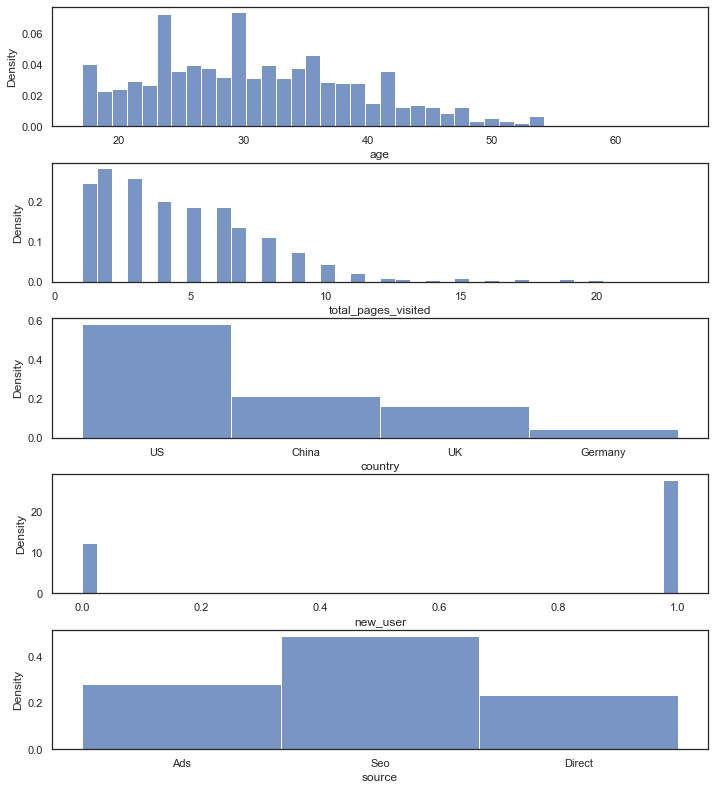

In [112]:
# Distribution des variables
cols = ['age','total_pages_visited','country','new_user','source']
fig, ax = plt.subplots(len(cols),1,figsize= (10,11))
#ax=ax.reshape(-1)
fig.tight_layout()

for idx,col in enumerate(cols):

    sns.histplot(data=data,x=col,ax=ax[idx],bins=40,stat="density")

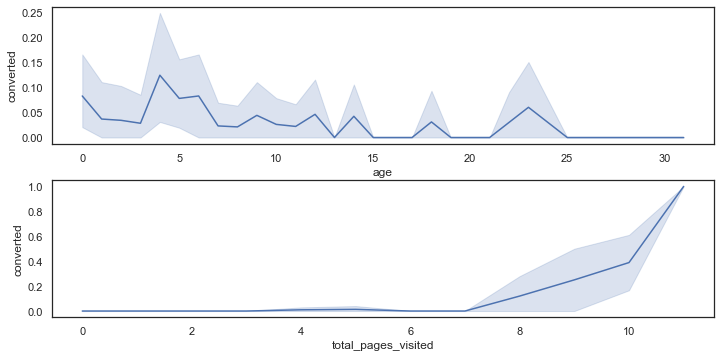

In [113]:
# Analyse : variable à prédire en fonction des variables numériques

cols = ['age','total_pages_visited']
fig, ax = plt.subplots(len(cols),1,figsize= (10,5))
#ax=ax.reshape(-1)
fig.tight_layout()
for idx,col in enumerate(cols):
    
    bins=pd.qcut(data[col], q=50, labels=False, duplicates="drop")
    sns.lineplot(data=data,x=bins,y="converted",ax=ax[idx])

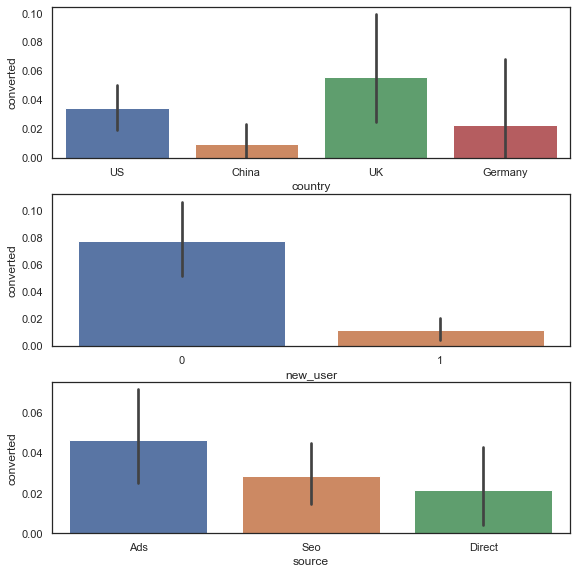

In [114]:
# Analyse : variable à prédire en fonction des variables catégorielles

cols = ['country','new_user','source']
fig, ax = plt.subplots(len(cols),1,figsize= (8,8))
#ax=ax.reshape(-1)
fig.tight_layout()
for idx,col in enumerate(cols):
    sns.barplot(data=data,x=col,y="converted",ax=ax[idx])

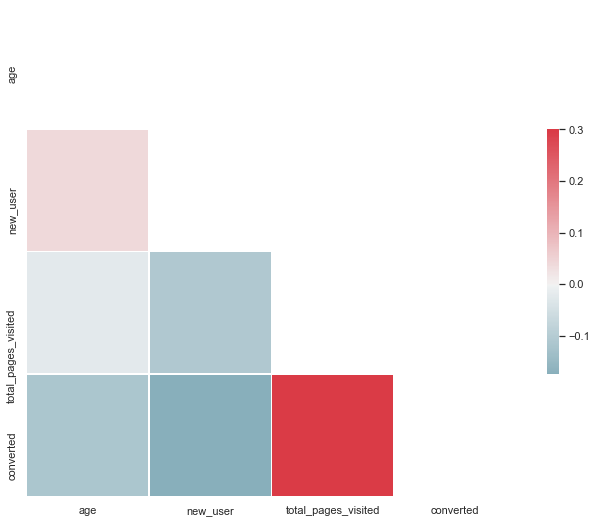

In [115]:
# Etude des corrélations
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
plot_correlation_heatmap(data)

<AxesSubplot:>

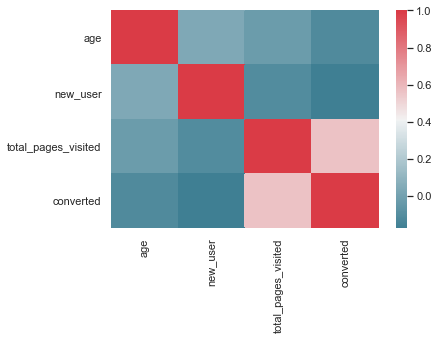

In [116]:
corr = data.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,cmap=cmap)

<AxesSubplot:xlabel='total_pages_visited', ylabel='age'>

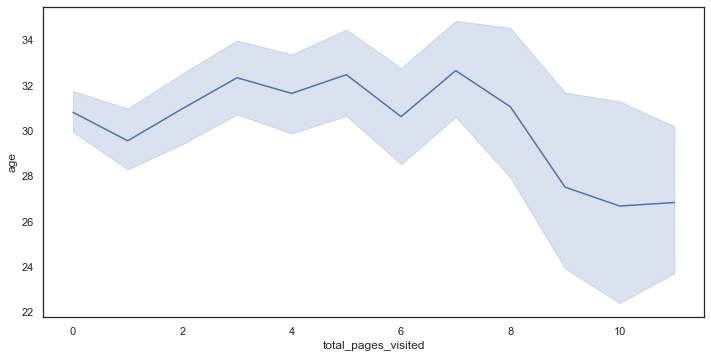

In [117]:
cols = ['total_pages_visited']
fig, ax = plt.subplots(len(cols),1,figsize= (10,5))
#ax=ax.reshape(-1)
fig.tight_layout()

bins=pd.qcut(data["total_pages_visited"], q=50, labels=False, duplicates="drop")
sns.lineplot(data=data,x=bins,y="age",ax=ax)

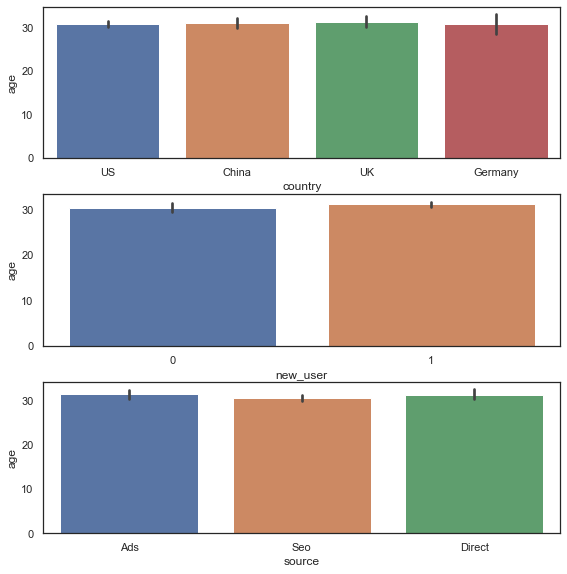

In [118]:
cols = ['country','new_user','source']
fig, ax = plt.subplots(len(cols),1,figsize= (8,8))
#ax=ax.reshape(-1)
fig.tight_layout()
for idx,col in enumerate(cols):
    sns.barplot(data=data,x=col,y="age",ax=ax[idx])

In [119]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(data);
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=1500, width = 1200)

# Make your model

In [120]:


def process_age(df):
    """Catégories d'age """
    cut_points = [16,25,30,35,40,150]
    label_names = ["20-25","25-30","30-35","35-40","40+"]
    df.loc[:,"age_categories"] = pd.cut(df["age"],cut_points,labels=label_names)
    return df

data= process_age(data)


## Choose variables to use in the model, and create train and test sets


In [121]:
features_list = ['country','new_user','age']
numeric_indices = []
categorical_indices = [0,1,2]
target_variable = 'converted'

In [122]:
X = data.loc[:, features_list]
X_full = data_full.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

unique_val = []
for i in categorical_indices:
    unique = np.sort(X_full.iloc[:,i].unique())
    unique_val.append(unique)

Explanatory variables :  Index(['country', 'new_user', 'age'], dtype='object')



In [123]:
unique

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  72,  73,  77,  79, 111, 123], dtype=int64)

In [124]:
# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

In [125]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

## Training pipeline

In [126]:
# Put here all the preprocessings

# Create pipeline for numeric features
# normalization
   
numeric_transformer = Pipeline(steps=[ # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])
# Create pipeline for categorical features

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(categories=unique_val,drop='first'))
    ])

# Encoding categorical features and standardizing numerical features

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)

In [127]:
# Train model
#classifier = LogisticRegression() # 
classifier = RandomForestClassifier(n_estimators=120)
%time classifier.fit(X_train, Y_train)

Wall time: 282 ms


RandomForestClassifier(n_estimators=120)

In [128]:
Y_train_proba = classifier.predict_proba(X_train)[:,1]
mask = Y_train_proba>0.1
(mask).sum()/len(Y_train_proba)

0.1325

In [129]:
Y_train_pred = np.zeros((len(Y_train_proba)))
Y_train_pred[mask] = 1

## Test pipeline

In [130]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)
X_test = featureencoder.transform(X_test)

In [131]:
# Predictions on test set
Y_test_proba = classifier.predict_proba(X_test)[:,1]
mask = Y_test_proba>0.13

Y_test_pred = np.zeros((len(Y_test_proba)))
Y_test_pred[mask] = 1

## Performance assessment

In [132]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.34848484848484845
f1-score on test set :  0.09090909090909091


In [133]:
print("Cross validated F1 score on training set : ", cross_val_score(classifier,X_train, Y_train,cv=10,scoring='f1').mean())
print("standard deviation : ", cross_val_score(classifier,X_train, Y_train,cv=10,scoring='f1').std())

Cross validated F1 score on training set :  0.0
standard deviation :  0.0


In [134]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[691  83]
 [  3  23]]

Confusion matrix on test set : 
[[179  15]
 [  5   1]]



In [135]:
param ={
            "n_estimators": np.arange(1,200,30),
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "min_samples_split": [2, 3, 5]
        }
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid=param)
grid.fit(X_train,Y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 5, 10],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': array([  1,  31,  61,  91, 121, 151, 181])})

In [136]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_split': 2,
 'n_estimators': 1}

In [137]:
# Predictions on training set
Y_train_pred = grid.best_estimator_.predict(X_train)
Y_test_pred = grid.best_estimator_.predict(X_test)

In [138]:

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.0
f1-score on test set :  0.0


In [139]:
print("Cross validated F1 score on training set : ", cross_val_score(grid.best_estimator_,X_train, Y_train,cv=10,scoring='f1').mean())
print("standard deviation : ", cross_val_score(grid.best_estimator_,X_train, Y_train,cv=10,scoring='f1').std())

Cross validated F1 score on training set :  0.0
standard deviation :  0.0


In [140]:
from sklearn.svm import SVC
svc_param_grid = {"kernel":["linear","rbf"],
                "C":[10.0**i for i in np.arange(-5,3,1)]}
svc = SVC(kernel="linear")

svc_grid = GridSearchCV(svc, param_grid=svc_param_grid, cv = 5, return_train_score=True)

%time svc_grid.fit(X_train, Y_train)
svc_grid.best_params_

Wall time: 527 ms


{'C': 1e-05, 'kernel': 'linear'}

In [141]:
# Predictions on training set
Y_train_pred = svc_grid.best_estimator_.predict(X_train)
Y_test_pred = svc_grid.best_estimator_.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.0
f1-score on test set :  0.0


**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [142]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train.toarray(),X_test.toarray(),axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

RandomForestClassifier(n_estimators=120)

In [143]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country','new_user','age']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 0 28]
 ['UK' 1 22]
 ['China' 1 32]
 ['US' 1 32]
 ['China' 0 25]]


In [144]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
  (0, 1)	1.0
  (0, 14)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
  (1, 8)	1.0
  (2, 3)	1.0
  (2, 18)	1.0
  (3, 2)	1.0
  (3, 3)	1.0
  (3, 18)	1.0
  (4, 11)	1.0


In [145]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1

Y_without_labels_proba = classifier.predict_proba(X_without_labels)[:,1]
mask = Y_without_labels_proba>0.11

Y_without_labels_pred = np.zeros((len(Y_without_labels_proba)))
Y_without_labels_pred[mask] = 1


data = {
    'converted': Y_without_labels_pred
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**